<h1 style="font-family:Times New Roman; font-size: 300%"><center>Machine Learning For Physics;Project 3 </center></h1>
<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">RNG Seed Analysis</h2>

<p style="font-family:Times New Roman; font-size:120%">
    The following notebook is conducting an analysis on the random seeds used to initialize the HNN's. Typically, this is such an arbitrary thing that it is chosen almost at random. However, we investigate here how much this changes the behaviour of each method.
</p>

In [34]:
using Pkg; Pkg.activate("~/.julia/environments/v1.11.1")
Pkg.add("Revise"); using Revise
using Lux, Optimisers, Plots, Statistics, Random, LinearAlgebra, Zygote,Distributions,NBInclude
Pkg.add("MLUtils"); using MLUtils

includet("Data.jl")
includet("NeuralNetwork.jl")
using Base.Threads

┌ Warning: skipping callee Main.:(var"#RK4_step#95") (called by Main.RK4_step) due to AssertionError("isexpr(bodystmt, :call)")
└ @ LoweredCodeUtils ~/.julia/packages/LoweredCodeUtils/h7PQC/src/signatures.jl:328
  Activating project at `~/~/.julia/environments/v1.11.1`
   Resolving package versions...
  No Changes to `~/~/.julia/environments/v1.11.1/Project.toml`
  No Changes to `~/~/.julia/environments/v1.11.1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/~/.julia/environments/v1.11.1/Project.toml`
  No Changes to `~/~/.julia/environments/v1.11.1/Manifest.toml`


In [37]:
fieldd = meshgrid(20, train=false,range=2)
spring_field = grads_ideal_pend(fieldd).*0.1

t, x_train,y_train = generate_data(grads_ideal_pend, 25, 30, 4*pi, sigma=0.01, sampler=sample_pend, min_e=1.3, max_e=2.3) |>f32
_, x_test, y_test = generate_data(grads_ideal_pend, 1, 30, 4*pi, sigma=0.01, sampler=sample_pend, min_e=1.3, max_e=2.3) |>f32

x_Train = reshape(x_train, 2, 30*25)
y_Train = reshape(y_train, 2, 30*25)

train_data = DataLoader((x_Train,y_Train),batchsize=30)

25-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, batchsize=30)
  with first element:
  (2×30 Matrix{Float32}, 2×30 Matrix{Float32},)

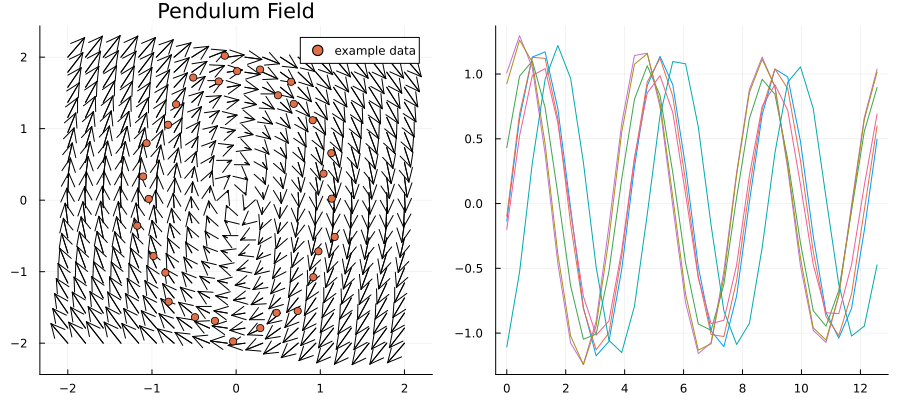

In [38]:
quiver(fieldd[1, :],fieldd[2, :],quiver=(spring_field[1, :], spring_field[2, :]), layout=(1,2),size=(900,400), title="Pendulum Field", label="train data",c=:black)
for i in 1:7
    plot!(t, x_train[1,:,i], subplot=2,legend=false)
end
scatter!(x_train[1,:,1], x_train[2,:,1], label="example data",subplot=1)

<h2 style="font-family:Times New Roman; font-size:200%">Conducting analysis</h2>

<p style="font-family:Times New Roman; font-size:120%">
    The only thing changed here wrt the Ideal Pendulum notebook is that the rng seed for initializing the weights for the HNN has been changed. The functions, and even the training data is completely identical. The results of this is striking!
</p>

In [27]:
activations = [tanh, sigmoid, mish, swish, gelu]
gains = [.01, .1, .5, 1, 2^0.5, 2, 5]
activations_str = ["tanh", "sigmoid", "mish", "swish", "gelu"]
gain_str = ["0.01", "0.1", "0.5", "1.0", "√2", "2.0", "5"]

MSE_valsk = zeros(length(activations), length(gains))
MSE_valsg = zeros(length(activations), length(gains))
MSE_valso = zeros(length(activations), length(gains))


Threads.@threads for a_idx in 1:length(activations)#for (a_idx, act) in enumerate(activations)
    act=activations[a_idx]
    
    Threads.@threads for g_idx in 1:length(gains)
        g_val=gains[g_idx]
        
        println("Doing $(activations_str[a_idx]) | Gain $(g_val)")
        
        _, LuxH_k = models(2, 64, act, Kaiming(g_val),1)
        _, LuxH_g = models(2, 64, act, Glorot(g_val),1)
        _, LuxH_o = models(2, 64, act, Orthogonal(g_val),1)
        
        #println(" -----  Training Kaiming  ----- ")
        pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=1200, rng_nr=42)
        lossk = lossHNN(LuxH_k, x_test,pHNN_k, sHNN_k ,y_test)
        MSE_valsk[a_idx,g_idx] = lossk
        
        #println(" -----  Training Glorot  ----- ")
        pHNN_g, sHNN_g = train_model(LuxH_g, lossHNN, train_data, x_test, y_test;epochs=1200, rng_nr=42)
        lossg = lossHNN(LuxH_g, x_test,pHNN_g, sHNN_g ,y_test)
        MSE_valsg[a_idx,g_idx] = lossg
        
        #println(" -----  Training Orthogonal  ----- ")
        pHNN_o, sHNN_o = train_model(LuxH_o, lossHNN, train_data, x_test, y_test;epochs=1200, rng_nr=42)
        losso = lossHNN(LuxH_o, x_test, pHNN_o, sHNN_o ,y_test)
        MSE_valso[a_idx,g_idx] = losso
    end
end

Doing tanh | Gain 5.0
Doing tanh | Gain 1.4142135623730951
Doing tanh | Gain 1.0
Doing mish | Gain 1.0
Doing mish | Gain 5.0
Doing mish | Gain 0.1
Doing mish | Gain 2.0
Doing tanh | Gain 0.5
Doing gelu | Gain 2.0
Doing gelu | Gain 0.01
Doing sigmoid | Gain 0.01
Doing gelu | Gain 0.5
Epoch=200 :loss = 0.95780313
Epoch=200 :loss = 0.41785926
Epoch=200 :loss = 0.406829
Doing sigmoid | Gain 2.0
Epoch=200 :loss = 0.45973474
Epoch=200 :loss = 0.4926829
Epoch=200 :loss = 0.54234296
Epoch=200 :loss = 0.47931418
Epoch=200 :loss = 7.9604697
Epoch=200 :loss = 0.5295694
Doing swish | Gain 0.5
Epoch=400 :loss = 0.37943122
Epoch=400 :loss = 0.38786
Epoch=400 :loss = 0.39682585
Epoch=200 :loss = 0.3942461
Epoch=200 :loss = 0.49633342
Epoch=400 :loss = 0.44807944
Epoch=400 :loss = 0.5137608
Epoch=400 :loss = 0.5416818
Epoch=400 :loss = 0.4724403
Epoch=600 :loss = 0.35203984
Epoch=600 :loss = 0.3882515
Epoch=600 :loss = 0.37987205
Epoch=400 :loss = 0.39030644
Epoch=600 :loss = 0.44325906
Epoch=200 :los

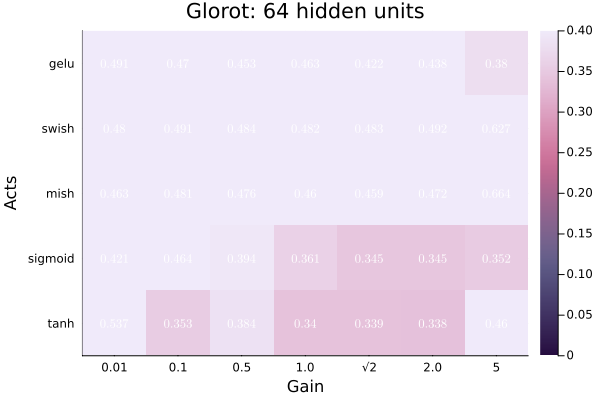

In [31]:
hg = heatmap(MSE_valsg, cmap=:acton,clim=(0, 0.4),title="Glorot: 64 hidden units",
    yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str), 
    ylabel="Acts",xlabel="Gain")
annotate!(hg,[(j, i, text(round(MSE_valsg[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
hg

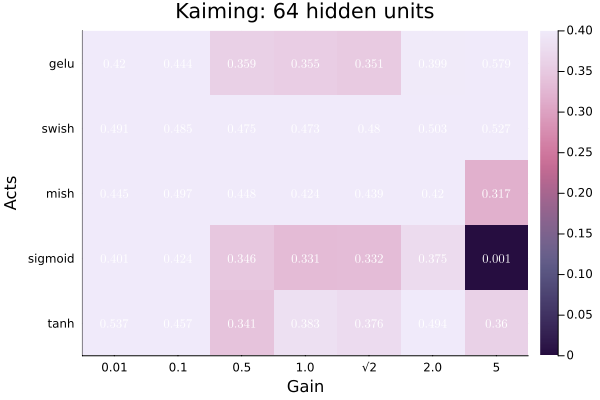

In [32]:
hk = heatmap(MSE_valsk, cmap=:acton, clim=(0,0.4),title="Kaiming: 64 hidden units",
             yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
              ylabel="Acts",xlabel="Gain")
annotate!(hk,[(j, i, text(round(MSE_valsk[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
hk

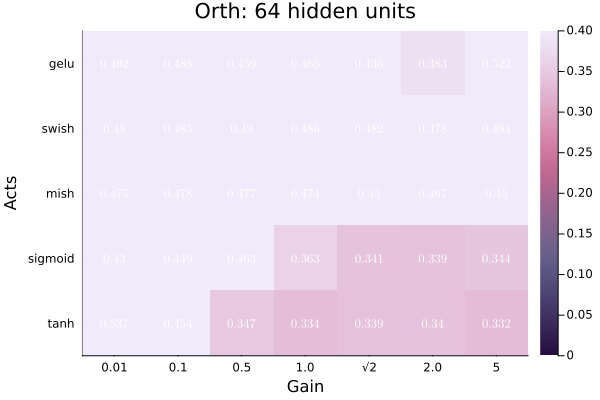

In [33]:
ho = heatmap(MSE_valso, cmap=:acton, clim=(0,0.4),title="Orth: 64 hidden units",
             yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
              ylabel="Acts",xlabel="Gain")
annotate!(ho,[(j, i, text(round(MSE_valso[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
ho

In [8]:
MSE_valsk = zeros(length(activations), length(gains))
MSE_valsg = zeros(length(activations), length(gains))
MSE_valso = zeros(length(activations), length(gains))


Threads.@threads for a_idx in 1:length(activations)
    act=activations[a_idx]
    
    Threads.@threads for g_idx in 1:length(gains)
        g_val=gains[g_idx]
        
        println("Doing $(activations_str[a_idx]) | Gain $(g_val)")
        
        _, LuxH_k = models(2, 200, act, Kaiming(g_val),1)
        _, LuxH_g = models(2, 200, act, Glorot(g_val),1)
        _, LuxH_o = models(2, 200, act, Orthogonal(g_val),1)
        
        #println(" -----  Training Kaiming  ----- ")
        pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=1200)
        lossk = lossHNN(LuxH_k, x_test,pHNN_k, sHNN_k ,y_test)
        MSE_valsk[a_idx,g_idx] = lossk
        
        #println(" -----  Training Glorot  ----- ")
        pHNN_g, sHNN_g = train_model(LuxH_g, lossHNN, train_data, x_test, y_test;epochs=1200)
        lossg = lossHNN(LuxH_g, x_test,pHNN_g, sHNN_g ,y_test)
        MSE_valsg[a_idx,g_idx] = lossg
        
        #println(" -----  Training Orthogonal  ----- ")
        pHNN_o, sHNN_o = train_model(LuxH_o, lossHNN, train_data, x_test, y_test;epochs=1200)
        losso = lossHNN(LuxH_o, x_test, pHNN_o, sHNN_o ,y_test)
        MSE_valso[a_idx,g_idx] = losso
    end
end

Doing tanh | Gain 1.0
Doing tanh | Gain 0.5
Doing tanh | Gain 1.4142135623730951
Doing tanh | Gain 0.01
Doing swish | Gain 0.01
Doing tanh | Gain 5.0
Doing gelu | Gain 5.0
Doing tanh | Gain 0.1
Doing sigmoid | Gain 1.0
Doing sigmoid | Gain 5.0
Doing mish | Gain 5.0
Doing gelu | Gain 0.01
Epoch=200 :loss = 0.6211503
Epoch=200 :loss = 0.45126608
Epoch=200 :loss = 0.38844392
Epoch=200 :loss = 0.5194764
Epoch=200 :loss = 0.36984462
Epoch=200 :loss = 0.28344697
Epoch=200 :loss = 0.33391327
Epoch=200 :loss = 0.47140044
Epoch=200 :loss = 0.612798
Epoch=200 :loss = 0.5746184
Doing swish | Gain 0.1
Epoch=400 :loss = 0.4652656
Epoch=400 :loss = 0.609133
Epoch=400 :loss = 0.395166
Epoch=400 :loss = 0.38641658
Epoch=400 :loss = 0.37653953
Epoch=400 :loss = 0.31826308
Epoch=400 :loss = 0.35430273
Epoch=400 :loss = 0.42985338
Epoch=400 :loss = 0.566677
Epoch=600 :loss = 0.39840946
Epoch=200 :loss = 0.9667331
Epoch=200 :loss = 0.5943371
Doing mish | Gain 0.5
Epoch=600 :loss = 0.5196654
Epoch=600 :los

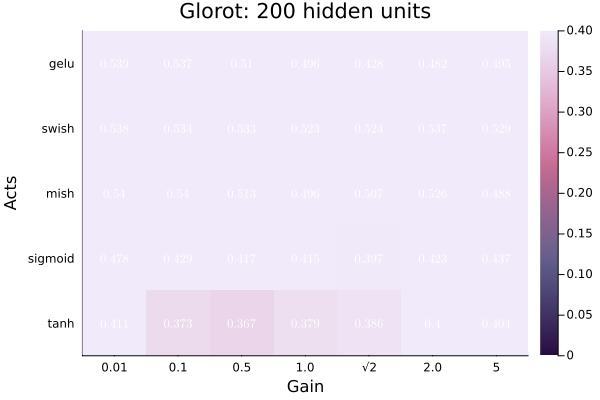

In [9]:
hg2 = heatmap(MSE_valsg, cmap=:acton,clim=(0, 0.4),title="Glorot: 200 hidden units", 
    yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
    ylabel="Acts",xlabel="Gain")
annotate!(hg2,[(j, i, text(round(MSE_valsg[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
hg2

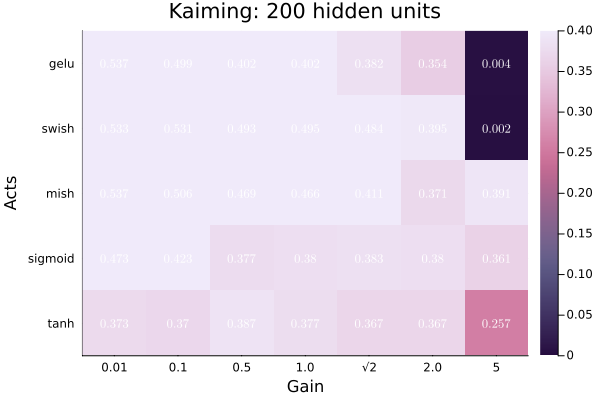

In [10]:
hk2 = heatmap(MSE_valsk, cmap=:acton, clim=(0,0.4),title="Kaiming: 200 hidden units",
             yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
              ylabel="Acts",xlabel="Gain")
annotate!(hk2,[(j, i, text(round(MSE_valsk[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
hk2


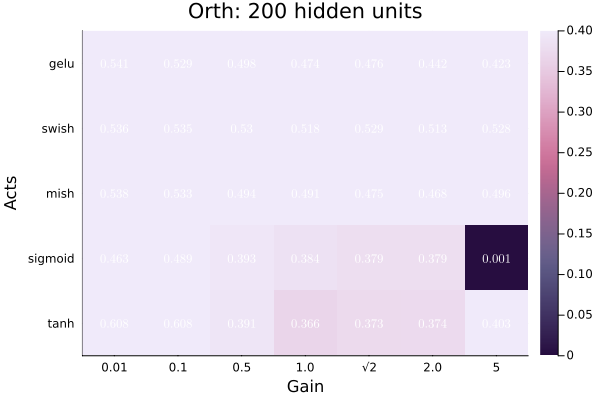

In [11]:
ho2 = heatmap(MSE_valso, cmap=:acton, clim=(0,0.4),title="Orth: 200 hidden units",
             yticks=(1:length(activations), activations_str), xticks=(1:length(gains), gain_str),
              ylabel="Acts",xlabel="Gain")
annotate!(ho2,[(j, i, text(round(MSE_valso[i,j],digits=3), 8,"Computer Modern",:white))
        for i in 1:length(activations) for j in 1:length(gains)])
ho2

<p style="font-family:Times New Roman; font-size:120%">
    By simply changing the random seed to 42, only four convergenceses has been seen here, accross all activation functions, with all gain-values, three initilization techniques considered and two different neural networks. Prevously, there were a considerable amount of combinations leading to convergent solutions, but now there is almost nothing? Why does this happen? We take a deeper look at what is going on prior to any training.
</p>

<h2 style="font-family:Times New Roman; font-size:200%">Analyzing Energy Heatmaps</h2>

<p style="font-family:Times New Roman; font-size:120%">
    As discussed in the project paper, the random seed has an abnormally large effect on the performance on each model. This is very strange, the data presented here motivates the pre-training scheme to be defined later.
</p>


In [12]:
p = range(-3,3,100)
q = range(-pi,pi,100)
p_m = repeat(p, inner=100)
q_m = repeat(q, outer=100)
matrix = hcat(q_m, p_m)' #Defining the data to find the heatmaps

2×10000 adjoint(::Matrix{Float64}) with eltype Float64:
 -3.14159  -3.07813  -3.01466  …  2.95119  3.01466  3.07813  3.14159
 -3.0      -3.0      -3.0         3.0      3.0      3.0      3.0

┌ Warning: Mixed-Precision `matmul_cpu_fallback!` detected and Octavian.jl cannot be used for this set of inputs (C [Matrix{Float64}]: A [Matrix{Float32}] x B [Adjoint{Float64, Matrix{Float64}}]). Falling back to generic implementation. This may be slow.
└ @ LuxLib.Impl ~/.julia/packages/LuxLib/wiiF1/src/impl/matmul.jl:145


Epoch=200 :loss = 0.49910954
Epoch=400 :loss = 0.42863104
Epoch=600 :loss = 0.38093123
Epoch=800 :loss = 0.37277752
Epoch=1000 :loss = 0.37075225
Epoch=1200 :loss = 0.3694975
Epoch=1400 :loss = 0.36861527
Epoch=1600 :loss = 0.36806324
Epoch=1800 :loss = 0.36788645
Epoch=2000 :loss = 0.36816624
Epoch=2200 :loss = 0.36899462
Epoch=2400 :loss = 0.36884797
Epoch=2600 :loss = 0.36044952
Epoch=2800 :loss = 0.35815415
Epoch=3000 :loss = 0.35645834
Epoch=3200 :loss = 0.35381618
Epoch=3400 :loss = 0.35076234
Epoch=3600 :loss = 0.3481192
Epoch=3800 :loss = 0.34601238
Epoch=4000 :loss = 0.34429598


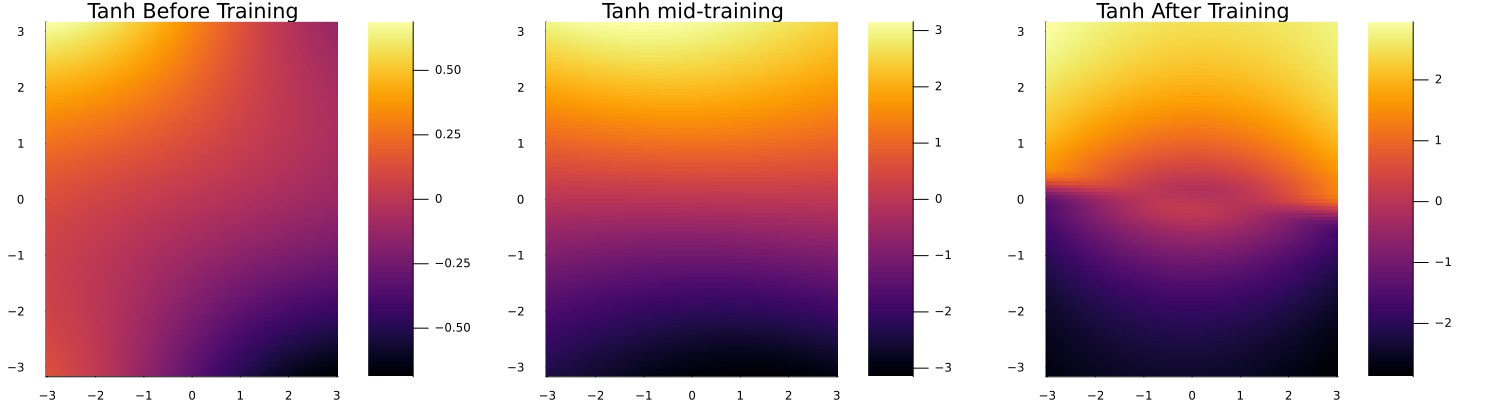

In [13]:
_, LuxH_k = models(2, 64, tanh, Glorot(1),1) #Fetch models, now a diverging model

# We display the model while it is not trained
pHNN_k, sHNN_k = Lux.setup(Random.MersenneTwister(4001), LuxH_k) 
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap(subplot=1,layout=(1,3),p,q, reshape(est, 100, 100),size=(1500,400),title="Tanh Before Training")

# We display the model when it has trained only for 3 epochs
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=3,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap!(p, q, subplot=2, reshape(est, 100, 100),title="Tanh mid-training")

# We display the model when it is trained and compare
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=4000,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap!(p, q, subplot=3, reshape(est, 100, 100),title="Tanh After Training")

Epoch=200 :loss = 0.0006916442
Epoch=400 :loss = 0.0010156452
Epoch=600 :loss = 0.0009451816
Epoch=800 :loss = 0.0009251901
Epoch=1000 :loss = 0.0009065064


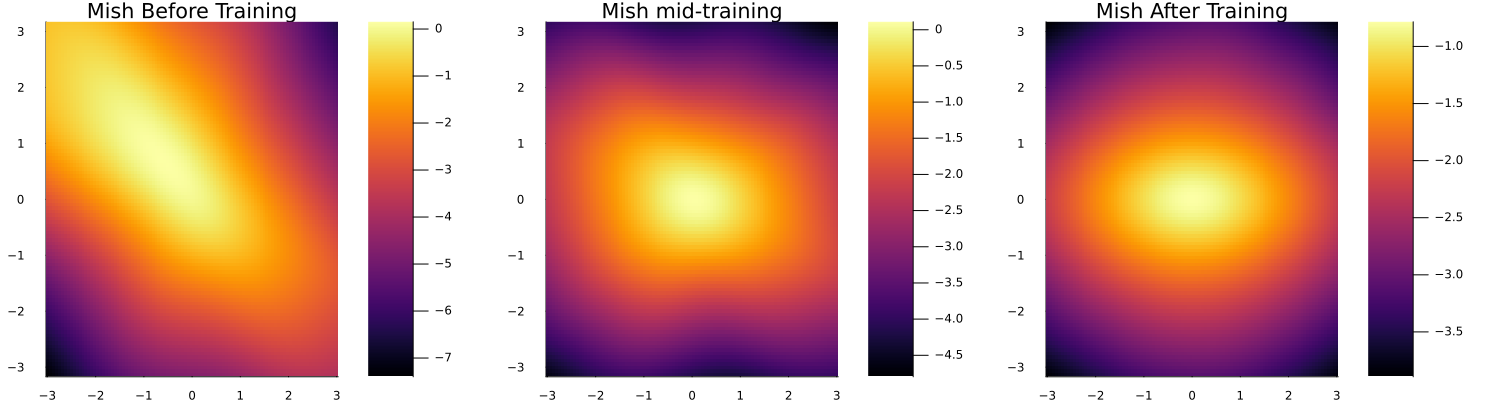

In [14]:
_, LuxH_k = models(2, 64, mish, Kaiming(2^0.5),1) #Fetch models, now a Converging model

# We display the model while it is not trained
pHNN_k, sHNN_k = Lux.setup(Random.MersenneTwister(4001), LuxH_k) 
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap(subplot=1,layout=(1,3),p,q, reshape(est, 100, 100),size=(1500,400),title="Mish Before Training")

# We display the model when it has trained only for 3 epochs
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=3,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap!(p, q, subplot=2, reshape(est, 100, 100),title="Mish mid-training")

# We display the model when it is trained and compare
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=1000,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap!(p, q, subplot=3, reshape(est, 100, 100),title="Mish After Training")

Epoch=200 :loss = 0.48177513
Epoch=400 :loss = 0.43695667
Epoch=600 :loss = 0.4010973
Epoch=800 :loss = 0.38554937
Epoch=1000 :loss = 0.38012794


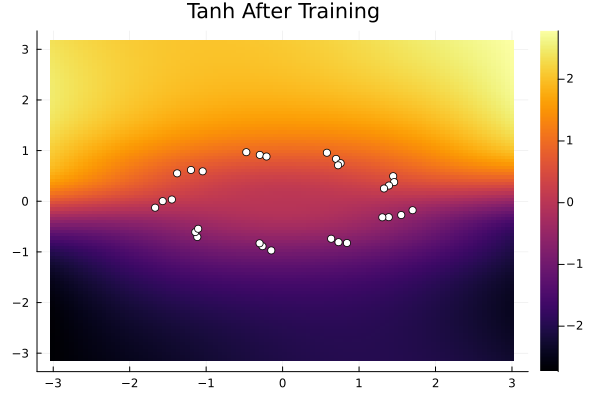

In [18]:
_, LuxH_k = models(2, 64, tanh, Glorot(5/3),1) #Plotting a converging method along the test data
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=1000,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap(p, q, reshape(est, 100, 100),title="Tanh After Training") #Plotting a non-converging method along the test data
scatter!(x_test[2,:],x_test[1,:],c=:white,legend=false)

Epoch=200 :loss = 0.00078798126
Epoch=400 :loss = 0.0011790895
Epoch=600 :loss = 0.00095874484
Epoch=800 :loss = 0.000864431
Epoch=1000 :loss = 0.00080413104


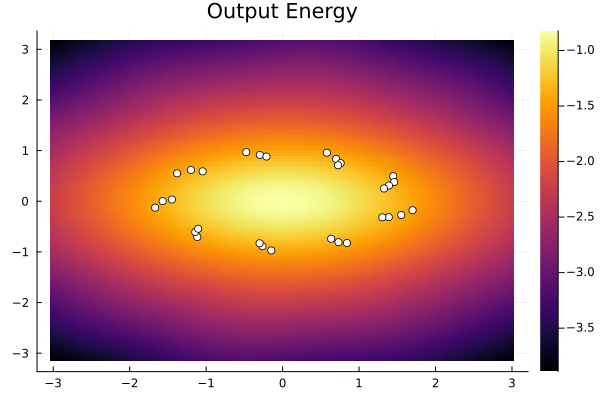

In [16]:
_, LuxH_k = models(2, 64, gelu, Kaiming(2^0.5),1) #Plotting a converging method along the test data
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=1000,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap(p, q, reshape(est, 100, 100),title="Output Energy")
scatter!(x_test[2,:],x_test[1,:],c=:white,legend=false)

Epoch=200 :loss = 0.52947664
Epoch=400 :loss = 0.5229437
Epoch=600 :loss = 0.5135504
Epoch=800 :loss = 0.4898408
Epoch=1000 :loss = 0.44544557


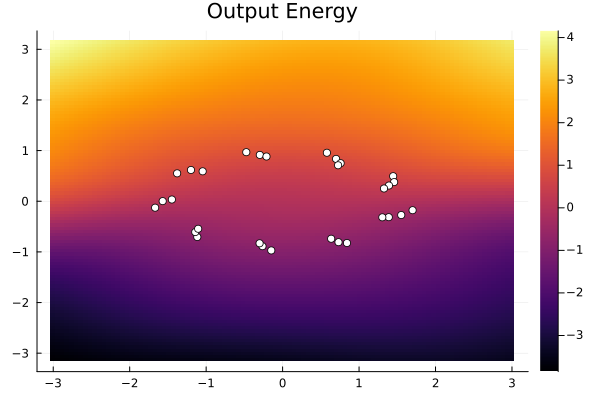

In [17]:
_, LuxH_k = models(2, 64, gelu, Glorot(2^0.5),1) #Plotting another non-converging method along the test data
pHNN_k, sHNN_k = train_model(LuxH_k, lossHNN, train_data, x_test, y_test;epochs=1000,rng_nr=4001)
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
heatmap(p, q, reshape(est, 100, 100),title="Output Energy")
scatter!(x_test[2,:],x_test[1,:],c=:white,legend=false)

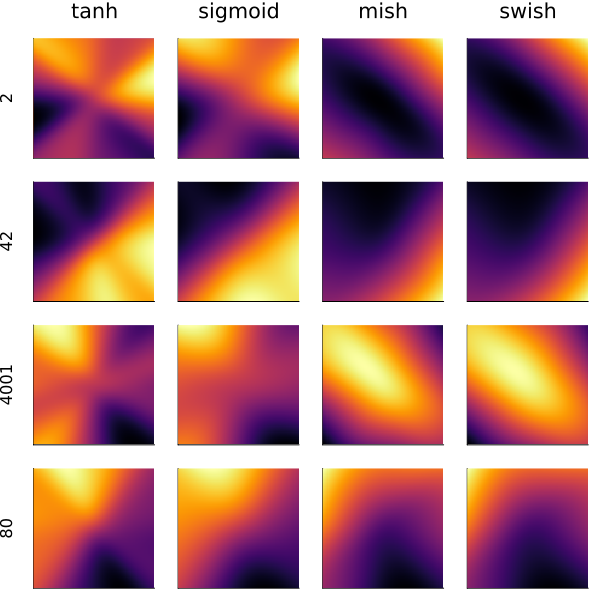

In [19]:
acts = [tanh, sigmoid, mish, swish]
act_str = ["tanh", "sigmoid", "mish", "swish"]
rng_vals = [2, 42, 4001, 80]

_, LuxH_k = models(2, 64, tanh, Kaiming(1),1) #Fetch models
pHNN_k, sHNN_k = Lux.setup(Random.MersenneTwister(1), LuxH_k) 
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
h=heatmap(p,q, reshape(est, 100, 100),layout=(4, 4),cbar=false,size=(600,600))
k=0
for (i,rng) in enumerate(rng_vals)
    for (j, act) in enumerate(acts)
        k+=1
        _, LuxH_k = models(2, 64, act, Kaiming(1),1) #Fetch models
        pHNN_k, sHNN_k = Lux.setup(Random.MersenneTwister(rng), LuxH_k) 
        smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
        est = smodel(matrix)
        if j==1
            y=rng
        else
            y=""
        end
        if i==1
            x=act_str[j]
        else
           x =""
        end
        
        heatmap!(h,p,q, reshape(est, 100, 100),subplot=k,cbar=false,xticks=false,yticks=false,ylabel=y,title=x)
    end
end
display(h)

Epoch=200 :loss = 0.37663004
Epoch=400 :loss = 0.3712474
Epoch=600 :loss = 0.369973
Epoch=800 :loss = 0.37035722
Epoch=1000 :loss = 0.37188223
Epoch=200 :loss = 0.43912822
Epoch=400 :loss = 0.40055484
Epoch=600 :loss = 0.3813004
Epoch=800 :loss = 0.37454817
Epoch=1000 :loss = 0.3719701
Epoch=200 :loss = 0.00067138736
Epoch=400 :loss = 0.0006152023
Epoch=600 :loss = 0.000647326
Epoch=800 :loss = 0.0006579933
Epoch=1000 :loss = 0.0006160172
Epoch=200 :loss = 0.0009270935
Epoch=400 :loss = 0.00073981
Epoch=600 :loss = 0.00066782173
Epoch=800 :loss = 0.00064239075
Epoch=1000 :loss = 0.00062544574
Epoch=200 :loss = 0.3845358
Epoch=400 :loss = 0.3797895
Epoch=600 :loss = 0.37766272
Epoch=800 :loss = 0.37599832
Epoch=1000 :loss = 0.37542346
Epoch=200 :loss = 0.42789182
Epoch=400 :loss = 0.39210996
Epoch=600 :loss = 0.3753476
Epoch=800 :loss = 0.36917228
Epoch=1000 :loss = 0.366547
Epoch=200 :loss = 0.49525163
Epoch=400 :loss = 0.46868902
Epoch=600 :loss = 0.44009274
Epoch=800 :loss = 0.413444

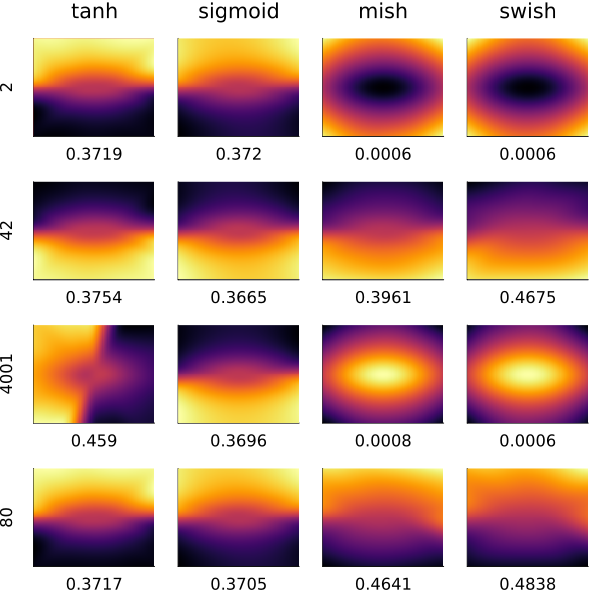

In [20]:
acts = [tanh, sigmoid, mish, swish]
act_str = ["tanh", "sigmoid", "mish", "swish"]
rng_vals = [2, 42, 4001, 80]

_, LuxH_k = models(2, 64, tanh, Kaiming(1),1) #Fetch models
pHNN_k, sHNN_k = Lux.setup(Random.MersenneTwister(1), LuxH_k) 
smodel = StatefulLuxLayer{true}(LuxH_k, pHNN_k, sHNN_k)
est = smodel(matrix)
h=heatmap(p,q, reshape(est, 100, 100),layout=(4, 4),cbar=false,size=(600,600))
k=0
for (i,rng) in enumerate(rng_vals)
    for (j, act) in enumerate(acts)
        k+=1
        _, LuxH = models(2, 64, act, Kaiming(1),1) #Fetch models
        pHNN, sHNN = train_model(LuxH, lossHNN, train_data, x_test, y_test;epochs=1000,rng_nr=rng)
        smodel = StatefulLuxLayer{true}(LuxH, pHNN, sHNN)
        est = smodel(matrix)
        if j==1
            y=rng
        else
            y=""
        end
        if i==1
            x=act_str[j]
        else
           x =""
        end
        
        heatmap!(h,p,q, reshape(est, 100, 100),subplot=k,
            cbar=false,xticks=false,yticks=false,
            ylabel=y,title=x,xlabel=round(lossHNN(LuxH,x_test, pHNN, sHNN, y_test),digits=4))
    end
end
display(h)

<p style="font-family:Times New Roman; font-size:120%">
    Looking closely on the similarities between the untrained and trained neural network output, there is a striking similarity between the initial guess from the models, and the final trained ones. If the initial guess is polarized, the final one is not only polarized, but along the very same axis, in the very same way. The model does however seem to make an attempt to redeem this horrible solution by doing some strange things in the middle of the plot, but this is a very poor attempt, and not a solution we are after! This is what happens when the models do not converge, and it is this that our pre-training algortihm will attempt to fix!
</p>